In [97]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import os, sys
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import graphviz
import joblib
import pickle
import lightgbm as lgbm
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold as KFold
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score

## xgBoost

In [76]:
train_df = pd.read_csv('/open/train_simple_preprocess.csv').iloc[:, 1:]
test_df = pd.read_csv('/open/test_simple_preprocess.csv').iloc[:, 1:]

In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   building_number       204000 non-null  int64  
 1   date_time             204000 non-null  object 
 2   temperature           204000 non-null  float64
 3   windspeed             204000 non-null  float64
 4   humidity              204000 non-null  float64
 5   building_type         204000 non-null  int64  
 6   solar_power_capacity  204000 non-null  int64  
 7   ess_capacity          204000 non-null  int64  
 8   pcs_capacity          204000 non-null  int64  
 9   ZEB                   204000 non-null  int64  
 10  THI                   204000 non-null  float64
 11  day                   204000 non-null  int64  
 12  month                 204000 non-null  int64  
 13  day_of_week           204000 non-null  int64  
 14  weekend               204000 non-null  int64  
 15  

In [78]:
## 평가 지표
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

In [79]:
## Validation Function

def xgb_objective(trial : Trial, train_x, train_y, train_index, valid_index):
    
    params_xgb = {
        'random_state' : 0,
        'early_stopping_rounds' : 50,
        'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'max_leaves': trial.suggest_categorical('max_leaves', [2**i for i in range(4, 10)]),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 300),
        # 'scale_pos_weight' : trial.suggest_uniform('scale_pos_weight', 1.2, 2.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.0, 1.0),
        'learning_rate':trial.suggest_uniform('learning_rate', 0.01, 0.05)
    }

    smape_list = []
    model_reg = xgb.XGBRegressor(**params_xgb)
    train_for_val_x, train_for_val_y = train_x.iloc[train_index], train_y.iloc[train_index]
    valid_x, valid_y = train_x.iloc[valid_index], train_y.iloc[valid_index]
    model_reg.fit(train_for_val_x, train_for_val_y, eval_set = [(train_for_val_x, train_for_val_y), (valid_x, valid_y)], verbose = False)
    xgb_pred = model_reg.predict(valid_x)
    smape = SMAPE(valid_y, xgb_pred)
    smape_list.append(smape) 

    trial.report(np.mean(smape_list), len(smape_list))
    
    if trial.should_prune():
        raise optuna.TrialPruned()

    
    return np.mean(smape_list)

In [80]:
## Train index, Valid index 생성

train_idx = train_df[lambda x: x['Day for Valid'] == 0].index
valid_idx = train_df[lambda x: x['Day for Valid'] == 1].index

print(len(train_idx), len(valid_idx)) # preprocessing과 일치

172800 31200


In [81]:
# X, y
train_df.drop(['date_time', 'Day for Valid', 'day'], axis = 'columns', inplace = True) # 모델 적용 과정에는 빼주기
test_df.drop(['date_time'], axis = 'columns', inplace = True)

X_train = train_df.drop('power', axis = 'columns')
y_train = train_df.loc[:, 'power']

In [87]:
sampler = TPESampler(seed = 42)

tuned_xgb = optuna.create_study(
    pruner = optuna.pruners.MedianPruner(),
    study_name = 'xgboost params',
    direction = 'minimize',
    sampler = sampler
)

obj_xgb = lambda trial : xgb_objective(trial, X_train, y_train, train_idx, valid_idx)
tuned_xgb.optimize(obj_xgb, n_trials = 150)

[I 2023-08-20 19:23:22,565] A new study created in memory with name: xgboost params
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_25848/3942941387.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_25848/3942941387.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
/var/folders/d7/8zsbg3r51rs_vl832mx18q_00000gn/T/ipykernel_25848/3942941387.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.co

In [94]:
tuned_xgb.best_params

{'n_estimators': 178,
 'max_depth': 15,
 'max_leaves': 16,
 'min_child_weight': 25,
 'reg_alpha': 0.0021572512818211318,
 'reg_lambda': 0.002162885251937809,
 'colsample_bytree': 0.9697082907626184,
 'subsample': 0.8437868211753716,
 'learning_rate': 0.04133144159966115}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

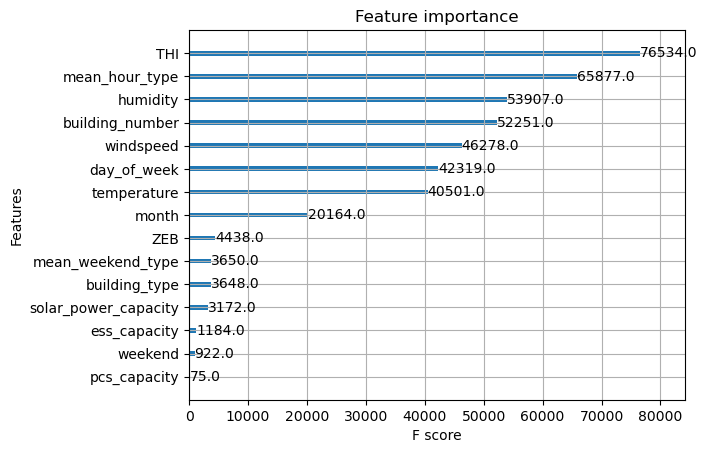

In [90]:
# best_parameters = {'n_estimators': 120, 'max_depth': 15, 'max_leaves': 128, 'min_child_weight': 45, 'scale_pos_weight': 1.4866705176753214, 'reg_alpha': 4.560653742463482e-07, 'reg_lambda': 0.026304812133574385, 'colsample_bytree': 0.768398606645231, 'subsample': 0.7549840918750791, 'learning_rate': 0.23156021599315557}

xgb_reg = xgb.XGBRegressor(**tuned_xgb.best_params)
# xgb_reg = XGBRegressor(**tuned_xgb.best_params)
xgb_reg.fit(X_train, y_train)
xgb.plot_importance(xgb_reg) # 변수 중요도

In [91]:
xgb_pred = xgb_reg.predict(test_df)


In [92]:
sample_submission = pd.read_csv('/Users/choeunsol/BOAZ/미니플젝/open/sample_submission.csv')
sample_submission.loc[:, 'answer'] = xgb_pred
sample_submission.to_csv('sample_submission.csv', index = False)

In [93]:
sample_submission

,num_date_time,answer
0,1_20220825 00,2122.049072
1,1_20220825 01,2159.497559
2,1_20220825 02,1964.783325
3,1_20220825 03,1951.276245
4,1_20220825 04,1912.198120
...,...,...
16795,100_20220831 19,927.977844
16796,100_20220831 20,819.640869
16797,100_20220831 21,703.431030
16798,100_20220831 22,584.599243


In [96]:
train_df.columns

Index(['building_number', 'temperature', 'windspeed', 'humidity',
       'building_type', 'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
       'ZEB', 'THI', 'month', 'day_of_week', 'weekend', 'mean_hour_type',
       'mean_weekend_type', 'power'],
      dtype='object')

In [99]:
## pickle 저장
joblib.dump(xgb_reg, 'model_xgboost_150.pkl')

['model_xgboost_150.pkl']

## ?

In [102]:
train_df_2 = pd.read_csv('/Users/choeunsol/BOAZ/미니플젝/open/train_simple_preprocess.csv').iloc[:, 1:]
test_df_2 = pd.read_csv('/Users/choeunsol/BOAZ/미니플젝/open/test_simple_preprocess.csv').iloc[:, 1:]

In [105]:
train_df_2.columns

Index(['building_number', 'date_time', 'temperature', 'windspeed', 'humidity',
       'building_type', 'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
       'ZEB', 'THI', 'day', 'month', 'day_of_week', 'weekend',
       'mean_hour_type', 'mean_weekend_type', 'power', 'Day for Valid'],
      dtype='object')